# HW 10 CLUSTERING BUSINESS
## Cluster time trends in NYC businesses:
### Data: 
Census Business data: http://www.census.gov/econ/cbp/download/  
NYC Zip code geojson: http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import zipfile
import urllib2
import geopandas as gp
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs

url = urllib2.urlopen("https://raw.githubusercontent.com/fedhere/PUI2015_fbianco/master/fbb_matplotlibrc.json")
s = json.load(url)
plt.rcParams.update(s)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/Dexter/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/Dexter/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
with open("nyc-zip-code-tabulation-areas-polygons.geojson") as zipjson:    
    zipcode = json.load(zipjson)
nyczip = []
for i in range (len(zipcode['features'])):
    nyczip.append(str(zipcode['features'][i]['properties']['postalCode']))

In [3]:
zdict = {}
for i in range(1994, 2014):
    if i in range(1998, 2003):
        fname = 'zbp' + str(i)[2:] + 'totals.zip'
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip', '.txt')))
        df = df.rename(columns={'ZIP': 'zip', 'EST': str(i)})
        df = df[(df.zip.astype(str).isin(nyczip))]
        zdict['{}'.format(i)] = df[['zip', str(i)]]
    else:
        fname = 'zbp' + str(i)[2:] + 'totals.zip'
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip', '.txt')))
        df = df.rename(columns={'est': str(i)})
        df = df[(df.zip.astype(str).isin(nyczip))]
        zdict['{}'.format(i)] = df[['zip', str(i)]]

df_concat = [zdict['1994'], zdict['1995'], zdict['1996'], zdict['1997'], zdict['1998'], zdict['1999'], zdict['2000'], zdict['2001'], zdict['2002'], zdict['2003'], zdict[
    '2004'], zdict['2005'], zdict['2006'], zdict['2007'], zdict['2008'], zdict['2009'], zdict['2010'], zdict['2011'], zdict['2012'], zdict['2013'], ]
df_all = reduce(lambda left, right: pd.merge(
    left, right, on='zip', how='inner'), df_concat)
df_all = df_all.set_index('zip')
print "Shape of the dataframe =", df_all.shape

Shape of the dataframe = (230, 20)


In [5]:
df_all = df_all.dropna()
df_norm = df_all
for i in range(len(df_norm)):
    df_norm.iloc[i] = (df_norm.iloc[i] - np.mean(df_norm.iloc[i])
                      ) / np.std(df_norm.iloc[i])

Best for 2 clusters: 0.561611135742


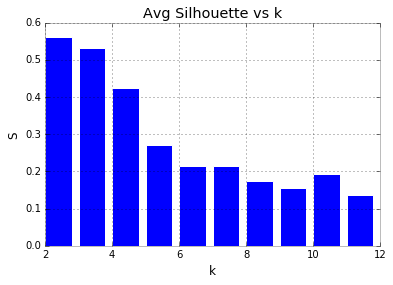

In [6]:
est = KMeans(n_clusters=3, n_init=100)
est.fit(df_norm)
labels = est.labels_
s = [0] * 10
for k in range(0, 10):
    est = KMeans(n_clusters=k + 2, n_init=150)
    est.fit(df_norm)
    s[k] = silhouette_score(df_norm, est.labels_)
k = np.argmax(s)
est = KMeans(n_clusters=k + 2, n_init=100)
est.fit(df_norm)
labels = est.labels_
plt.figure()
plt.bar(range(2, 12), s)
plt.xlabel('k')
plt.ylabel('S')
plt.title('Avg Silhouette vs k')
print('Best for {0} clusters: {1}'.format(
    k + 2, silhouette_score(df_norm, labels)))

[1995, 2013, -3, 4]

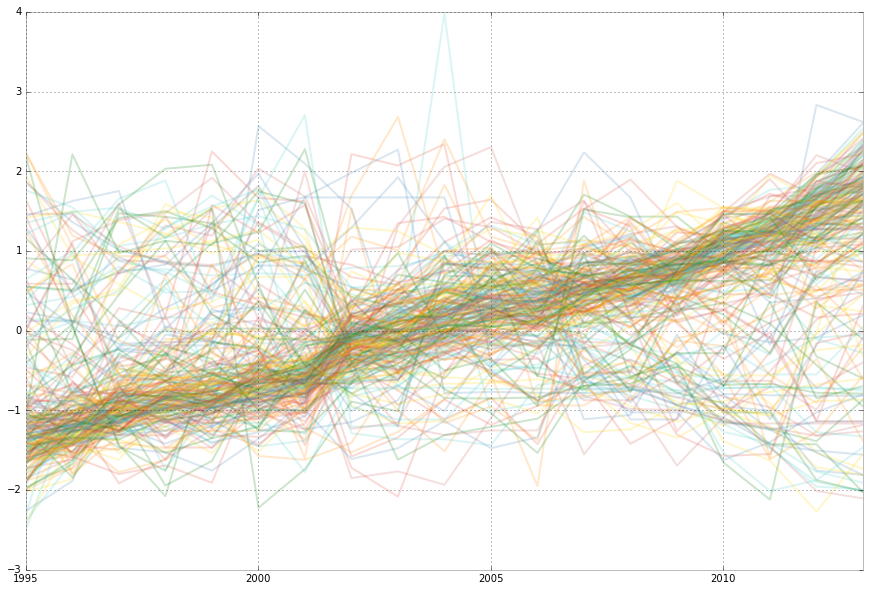

In [6]:
f = plt.figure(figsize=(15,10))
ax1 = plt.subplot(1,1,1)  
for i in range(len(df_norm)):
    plt.plot(range(1994,2014),df_norm.iloc[i], alpha=0.2)
plt.axis([1995, 2013, -3,4]) 

In [7]:
def kmcluster(n, dataset2):
    est = KMeans(n_clusters=n, n_init=100)
    est.fit(df_norm)
    labels = est.labels_
    df_label = pd.DataFrame({'label': labels})
    df_label.index = df_norm.index
    dataset3 = df_norm.join(df_label)
    return dataset3

In [8]:
def APcluster(dataset2):
    af = AffinityPropagation(preference=-50).fit(df_norm)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_
    df_label = pd.DataFrame({'label':labels})
    n_cluster = df_label.label.max()
    df_label.index = df_norm.index
    dataset3 = df_norm.join(df_label)
    return dataset3, n_cluster

In [9]:
def cluster_plot(n, dataset3):
    plt.figure(figsize=(15, 10))
    for i in range(len(df_norm)):
        plt.plot(range(1994, 2014), df_norm.iloc[i], 'grey', alpha=0.2)
    for i in range(n):
        data_byl = dataset3[dataset3['label'] == i]
        m = len(data_byl)
        sum_zip = 0
        for i in range(m):
            sum_zip = sum_zip + data_byl.iloc[i]
        avg_zip = sum_zip[0:len(sum_zip) - 1] / m
        plt.plot(range(1994, 2014), avg_zip, linewidth=15, alpha=0.8)
    plt.axis([1995, 2013, -3, 4])

In [10]:
def cluster_geoplot(n, dataset3):
    zip_plot = gp.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
    zip_data = pd.DataFrame(
        {'postalCode': df_norm.index, 'label': dataset3['label']})
    for i in range(len(zip_plot)):
        zip_plot['postalCode'][i] = int(zip_plot['postalCode'][i])
    zip_plot = pd.merge(zip_plot, zip_data)
    zip_plot.plot(column='label', figsize=(15, 15),
                  categorical=True, legend=True, alpha=0.7)

In [11]:
def kcluster_p(n):
    cluster_n = kmcluster(n, df_norm)
    cluster_plot(n, cluster_n)
    cluster_geoplot(n, cluster_n)

In [14]:
def APcluster_p():
    cluster_n, n = APcluster(df_norm)
    cluster_plot(n+1, cluster_n)
    cluster_geoplot(n+1, cluster_n)

## K Means Algorithm:

/Users/Dexter/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


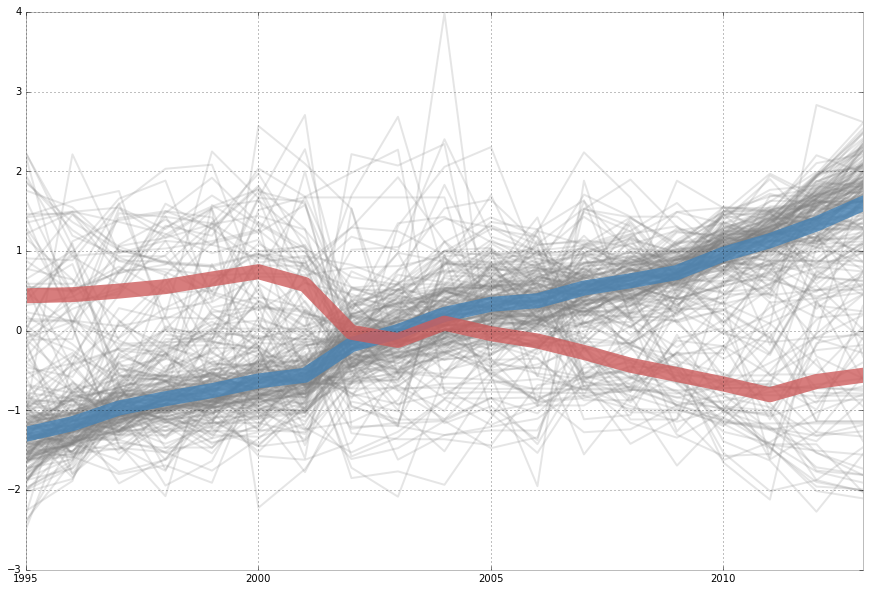

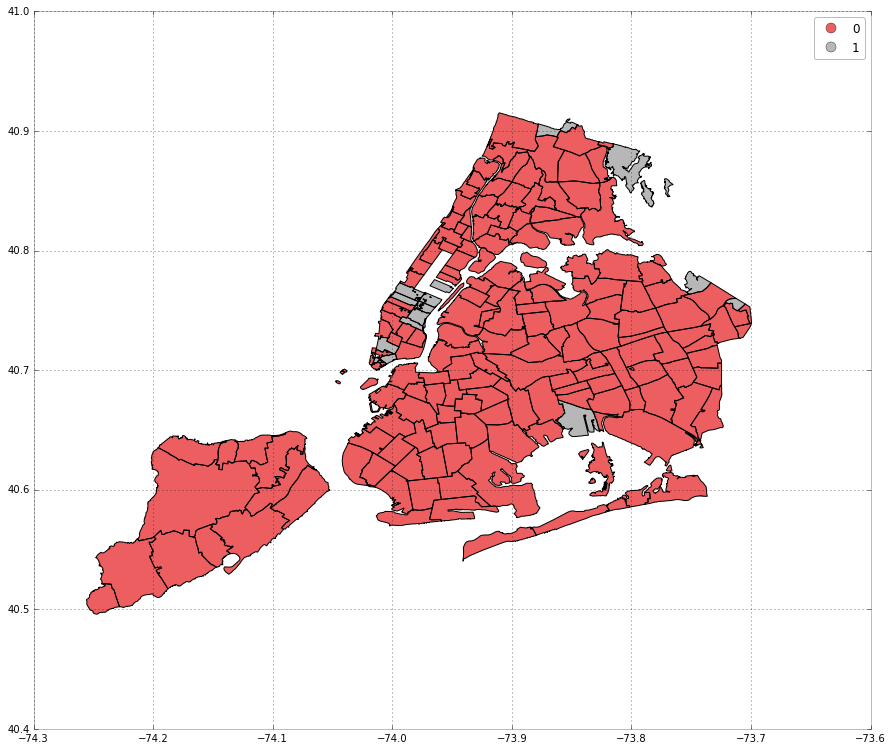

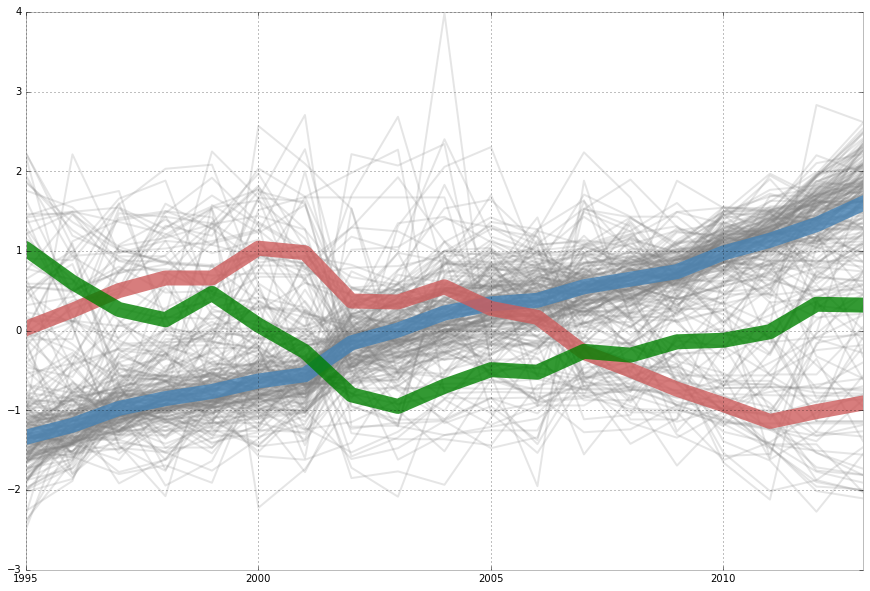

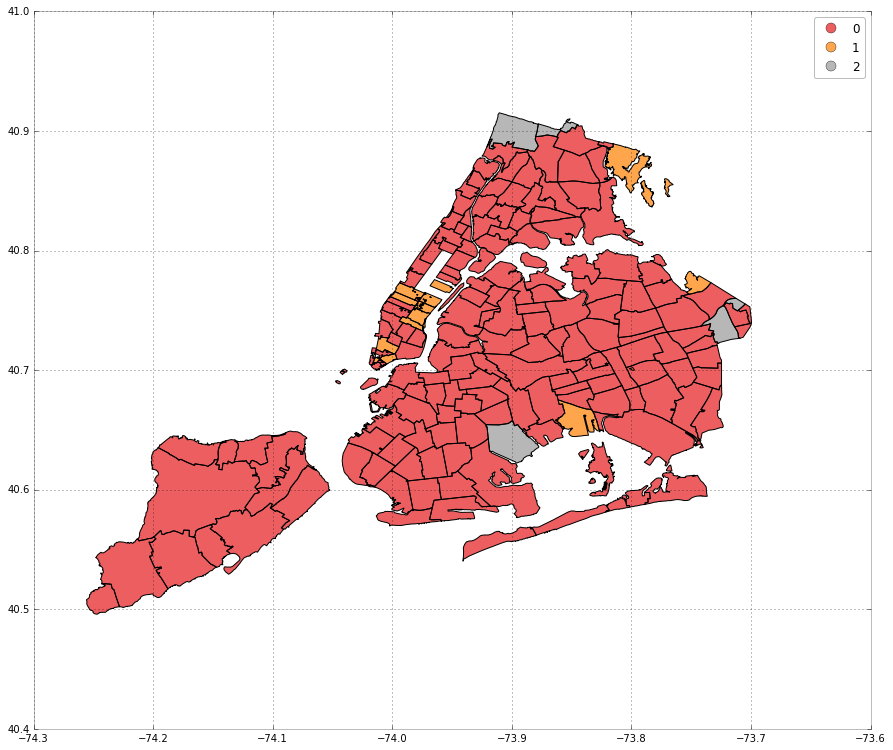

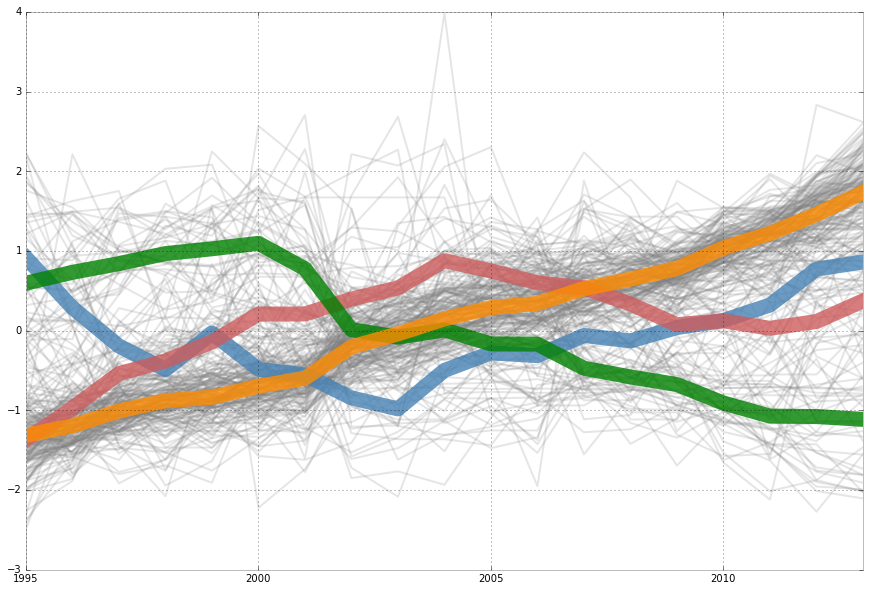

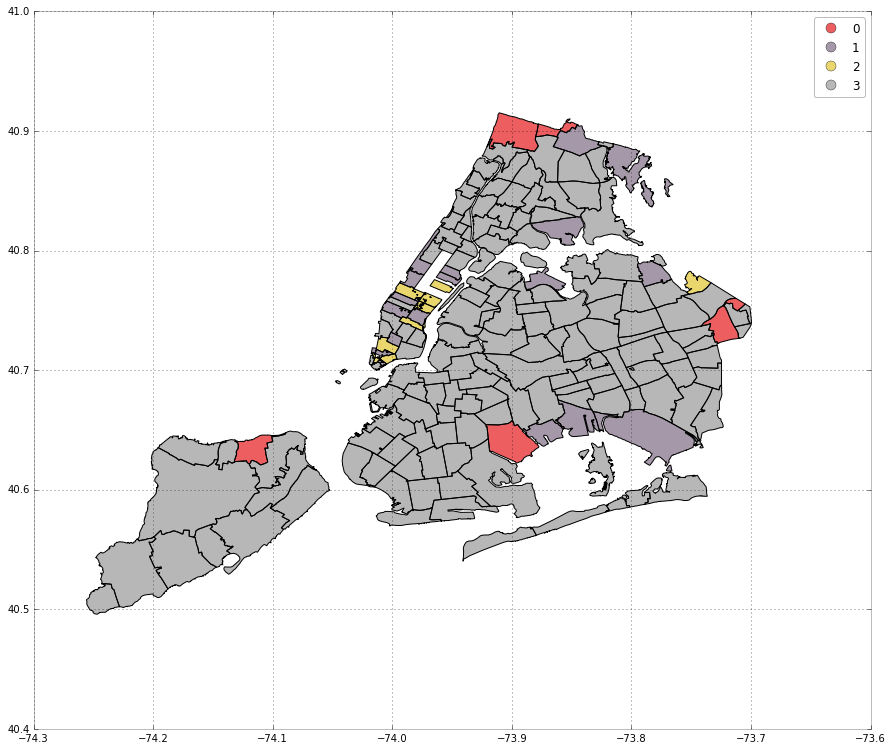

In [13]:
for i in range(2,5):
    kcluster_p(i)

/Users/Dexter/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


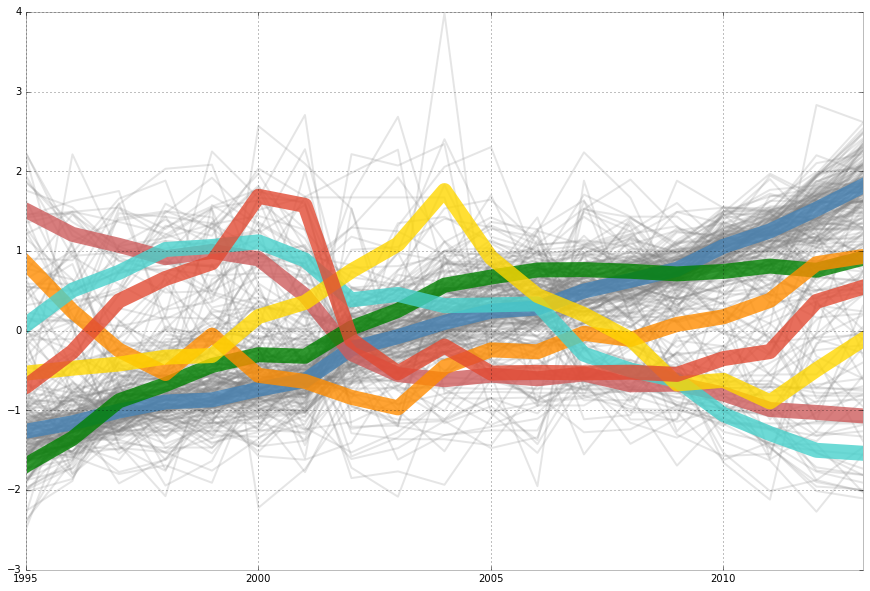

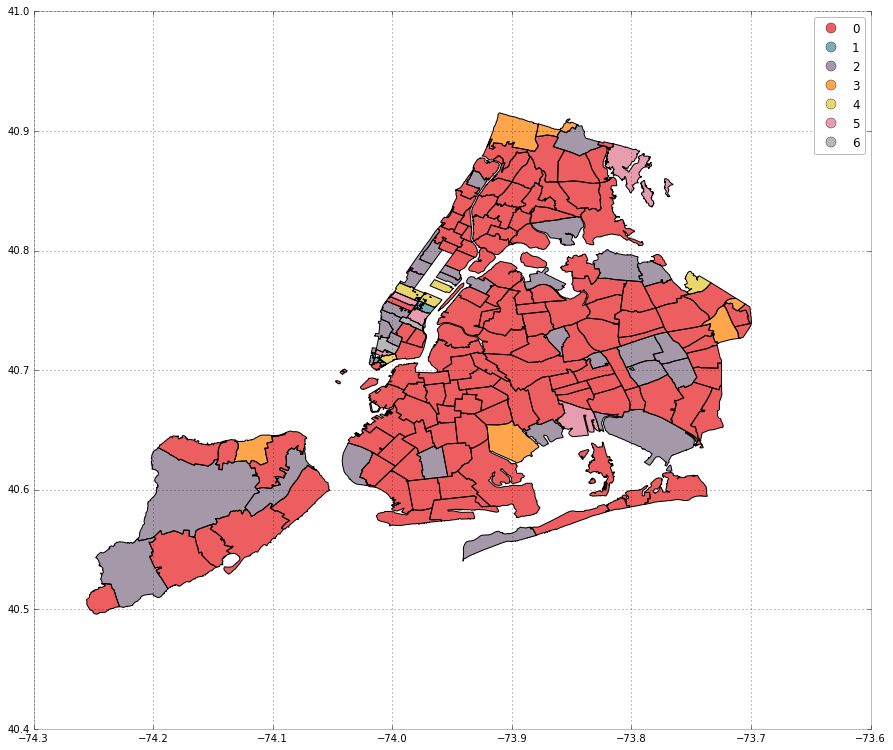

In [56]:
kcluster_p(7)

## Affinity Propagation Algorithm:

/Users/Dexter/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


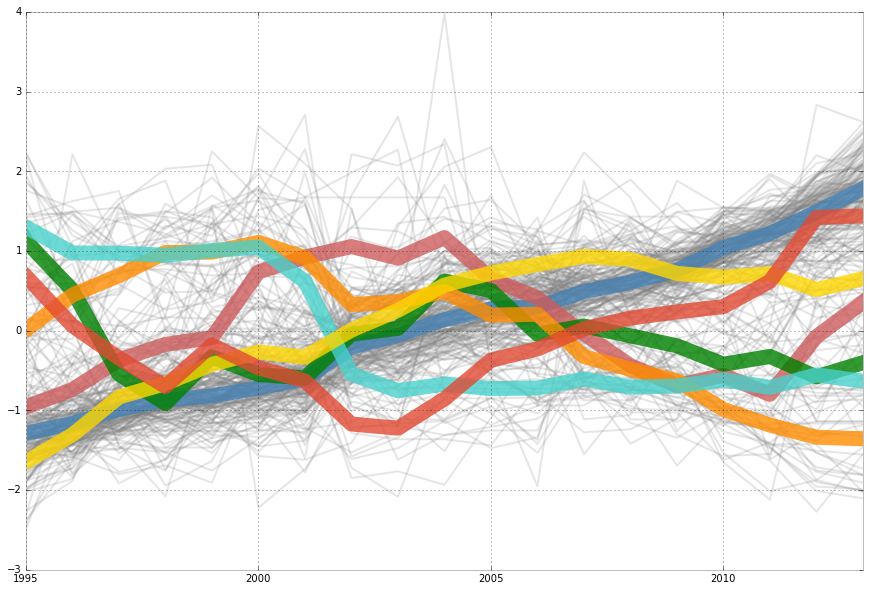

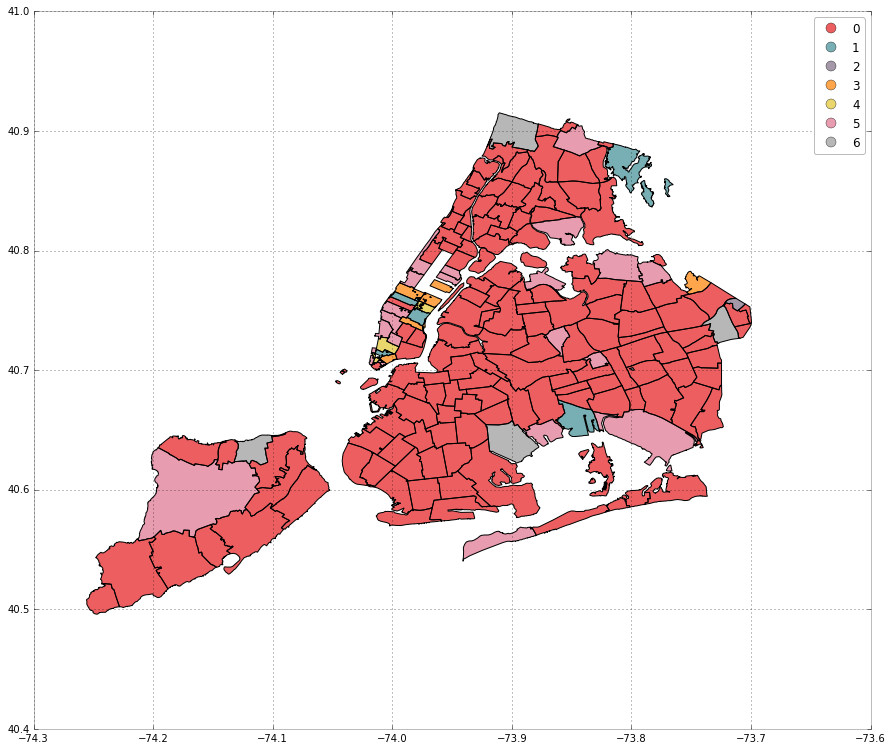

In [15]:
APcluster_p()

## Comparison of 2 Algorithms
Based on the result I got (pretty similar), it is still hard to differentiate the performance of these 2 algorithms. In terms of efficiency, I think K means clustering is better since it consumes less computational power. However, it needs a good choice of number of clusters (which can done by calculating Siloutte score). With the number of clusters determined, it generally gives a meanningful result.

Unlike clustering algorithms such as k-means, Affinty Propagation algorithm does not require the number of clusters to be determined or estimated before running the algorithm. In fact, for this case, 7 clusters had been chosen and the result was similar to the one calculated by K means. Therefore, it is more convenient for beginners but it consumes more computational power.

## Interpretation
As we can see from the plot, in general, the businesses had been increased in most areas of New York City. Nearly all other clusters are located in the borders on the city. It is also noticable that in most part of the manhattan, the business seems to grow in a much slower pace which might due to the reason that they are reaching the limit of capacity. Some areas such as midtown, downtown and flushing shows the trend of slight decrease, too.